# Impact of bit collisions on learning performance - LITPCBA




In [8]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())
%pylab inline

2022.09.1
Wed Dec 28 07:37:11 2022
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [9]:
import os
import glob
datasets = [x for x in glob.glob('/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/*') if 'README' not in x]
len(datasets)

15

In [10]:
datasets

['/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53',
 '/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR']

In [2]:
!wc -l /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2/*.smi

      13 /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2/AID492947_active_T.smi
       4 /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2/AID492947_active_V.smi
  234363 /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2/AID492947_inactive_T.smi
   78120 /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2/AID492947_inactive_V.smi
  312500 total


In [60]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from bayes.LaplacianNB import LaplacianNB
from xgboost import XGBClassifier

import random
import pickle
import gzip

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score
)
import ghostml

metrics = {
    'precision_score':precision_score,
    'recall_score':recall_score,
    'accuracy_score':accuracy_score,
    'balanced_accuracy_score':balanced_accuracy_score,
    'f1_score':f1_score,
    'cohen_kappa_score':cohen_kappa_score,
}

def run_target(tgt,fpnm,fpgen,cls,inactMult=-1,sparse=False):
    print(f'*** Running target {tgt}')

    tgtn = tgt.split('/')[-1]
    fn = f'results/{tgtn}.{fpnm}.pkl.gz'
    if os.path.exists(fn):
        print('   Reading fingerprints')
        with gzip.open(fn,'rb') as inf:
            fps_T,fps_V,nActs_T,nActs_V,nInacts_T,nInacts_V = pickle.load(inf)
    else:
        print('   Generating fingerprints')
        tn = glob.glob(os.path.join(tgt,'*_active_T.smi'))
        fps_T = [fpgen.GetFingerprintAsNumPy(x) for x in Chem.SmilesMolSupplier(tn[0],titleLine=False) if x is not None]
        nActs_T = len(fps_T)

        tn = glob.glob(os.path.join(tgt,'*_inactive_T.smi'))
        fps_T.extend(fpgen.GetFingerprintAsNumPy(x) for x in Chem.SmilesMolSupplier(tn[0],titleLine=False) if x is not None)
        nInacts_T = len(fps_T) - nActs_T


        tn = glob.glob(os.path.join(tgt,'*_active_V.smi'))
        fps_V = [fpgen.GetFingerprintAsNumPy(x) for x in Chem.SmilesMolSupplier(tn[0],titleLine=False) if x is not None]
        nActs_V = len(fps_V)

        tn = glob.glob(os.path.join(tgt,'*_inactive_V.smi'))
        fps_V.extend(fpgen.GetFingerprintAsNumPy(x) for x in Chem.SmilesMolSupplier(tn[0],titleLine=False) if x is not None)
        nInacts_V = len(fps_V) - nActs_V

        with gzip.open(fn,'wb+') as outf:
            pickle.dump((fps_T,fps_V,nActs_T,nActs_V,nInacts_T,nInacts_V),outf)

    if inactMult > 0:
        nInacts_T = min(nInacts_T,inactMult*nActs_T,10000)
        fps_T = fps_T[:(nActs_T+nInacts_T)]
        nInacts_V= min(nInacts_V,inactMult*nActs_V,10000)
        fps_V = fps_V[:(nActs_V+nInacts_V)]
            
    labels_T = [1]*nActs_T + [0]*nInacts_T
    labels_V = [1]*nActs_V + [0]*nInacts_V    
    

    res = {}
    res['nActs_V']=nActs_V
    res['nActs_T']=nActs_T
    res['nInacts_V']=nInacts_V
    res['nInacts_T']=nInacts_T

    
    print('   Building model')
    random.seed(0xbadd06)
    order_T = list(range(len(labels_T)))
    random.shuffle(order_T)
    order_V = list(range(len(labels_V)))
    random.shuffle(order_V)

    X_T = np.take(fps_T,order_T,axis=0)
    X_V = np.take(fps_V,order_V,axis=0)
    y_T = np.take(labels_T,order_T)
    y_V = np.take(labels_V,order_V)

    # clear up memory
    fps_T = None
    fps_V = None
    
    if sparse:
        X_T = [set(np.where(v)[0]) for v in X_T]
        X_V = [set(np.where(v)[0]) for v in X_V]

    
    cls.fit(X_T,y_T)
    

    pred_probs = [x[1] for x in cls.predict_proba(X_V)]
    pred_order = list(np.argsort(pred_probs))
    pred_order.reverse()
    pred_probs = np.take(pred_probs,pred_order)
    true_labels = np.take(y_V,pred_order)

    
    pred_labels = [1 if x>=0.5 else 0 for x in pred_probs]
    for metric in metrics:
        res[metric] = metrics[metric](true_labels,pred_labels)

    train_probs = [x[1] for x in cls.predict_proba(X_T)]    
    thresh = ghostml.optimize_threshold_from_predictions(y_T,train_probs,thresholds=np.arange(0.05,0.5,0.05))
    res['ghost_thresh'] = thresh
    pred_labels = [1 if x>=thresh else 0 for x in pred_probs]
    for metric in metrics:
        res[metric+'_ghost'] = metrics[metric](true_labels,pred_labels)

    res['roc_auc_score'] = roc_auc_score(true_labels,pred_probs)
    res['average_precision_score'] = average_precision_score(true_labels,pred_probs)
    print('Done!')
    return res
    

In [32]:
accum = defaultdict(dict)

In [5]:
with open('bak.pkl','rb') as inf:
    accum = pickle.load(inf)


In [1]:
!cp bak.pkl bak2.pkl

In [6]:
from collections import defaultdict

gens = [('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
          
         ]
#accum = defaultdict(dict)

for fpcnt in (1024,8192):   
    print(f'-------------- {fpcnt} Bits')
    for nm,fpg in gens:
        print(f'  --------- {nm}')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for tgt in datasets:
            if fpkey in accum['rf'] and tgt in accum['rf'][fpkey]:
                continue

#             print('  lmnb')
#             cls =  LaplacianNB(alpha=1.0, fit_prior=True)
#             if nm not in accum['lmnb']:
#                 accum['lmnb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
#             accum['lmnb'][f'{nm}-{fpcnt}'][tgt] = run_target(tgt,f'{nm}-{fpcnt}',fpgen,cls)

            print('  XGB')
            cls = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=6)
            if fpkey not in accum['xgb']:
                accum['xgb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
            accum['xgb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)

            print('  BRF')
            cls = BalancedRandomForestClassifier(n_estimators=500,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['brf']:
                accum['brf'][fpkey] = defaultdict(dict)
            accum['brf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)
            
            print('  RF')
            cls = RandomForestClassifier(n_estimators=500,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['rf']:
                accum['rf'][fpkey] = defaultdict(dict)
            accum['rf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)

            with open('bak.pkl','wb+') as outf:
                pickle.dump(accum,outf)


-------------- 1024 Bits
  --------- mfp2
  --------- mfp3
  --------- rdk5
  --------- hashap
  --------- hashtt
-------------- 8192 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbias

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!


In [8]:
!cp bak.pkl bak.8192.pkl

In [10]:
accum = defaultdict(dict)

In [ ]:
from collections import defaultdict

gens = [('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
          
         ]
#accum = defaultdict(dict)

for fpcnt in (1024,16394):   
    print(f'-------------- {fpcnt} Bits')
    for nm,fpg in gens:
        print(f'  --------- {nm}')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for tgt in datasets:
            if fpkey in accum['rf'] and tgt in accum['rf'][fpkey]:
                continue

#             print('  lmnb')
#             cls =  LaplacianNB(alpha=1.0, fit_prior=True)
#             if nm not in accum['lmnb']:
#                 accum['lmnb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
#             accum['lmnb'][f'{nm}-{fpcnt}'][tgt] = run_target(tgt,f'{nm}-{fpcnt}',fpgen,cls)

#             print('  XGB')
#             cls = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=6)
#             if fpkey not in accum['xgb']:
#                 accum['xgb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
#             accum['xgb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)

            print('  BRF')
            cls = BalancedRandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['brf']:
                accum['brf'][fpkey] = defaultdict(dict)
            accum['brf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)
            
            print('  RF')
            cls = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['rf']:
                accum['rf'][fpkey] = defaultdict(dict)
            accum['rf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)

            with open('bak.16394.pkl','wb+') as outf:
                pickle.dump(accum,outf)


-------------- 1024 Bits
  --------- mfp2
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Readi

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
-------------- 16394 Bits
  --------- mfp2
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashap
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Generating fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Generating fingerprints
   Building model


In [39]:
accum['brf']['mfp2-1024'].keys()

dict_keys(['/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR'])

# Reduce the number of inactives

The full datasets were problematic for some of the methods (memory requirements) and took a long time to run. Speed things up by reducing the number of inactive molecules... target 1% active, max 10K inactives

In [14]:
from collections import defaultdict
accum = defaultdict(dict)

In [15]:
from collections import defaultdict

gens = [('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
          
         ]
#accum = defaultdict(dict)

# yes, 16394 is a typo...
for fpcnt in (1024,8192,16394):   
    print(f'-------------- {fpcnt} Bits')
    for nm,fpg in gens:
        print(f'  --------- {nm}')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for tgt in datasets:
            if fpkey in accum['rf'] and tgt in accum['rf'][fpkey]:
                continue

            print('  XGB')
            cls = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=6)
            if fpkey not in accum['xgb']:
                accum['xgb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
            accum['xgb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,inactMult=100)

            print('  lmnb')
            cls =  LaplacianNB(alpha=1.0, fit_prior=True)
            if fpkey not in taccum['lmnb']:
                accum['lmnb'][fpkey] = defaultdict(dict)
            accum['lmnb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,inactMult=100,sparse=True)

            print('  BRF')
            cls = BalancedRandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['brf']:
                accum['brf'][fpkey] = defaultdict(dict)
            accum['brf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,inactMult=100)
            
            print('  RF')
            cls = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['rf']:
                accum['rf'][fpkey] = defaultdict(dict)
            accum['rf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,inactMult=100)

            with open('results/litpcba.downsample.pkl','wb+') as outf:
                pickle.dump(accum,outf)


-------------- 1024 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fing

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
-------------- 8192 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fing

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fing

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
-------------- 16394 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!


In [21]:
accum['rf']['mfp2-1024']['/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2']

{'nActs_V': 4,
 'nActs_T': 13,
 'nInacts_V': 400,
 'nInacts_T': 1300,
 'precision_score': 0.0,
 'recall_score': 0.0,
 'accuracy_score': 0.9900990099009901,
 'balanced_accuracy_score': 0.5,
 'f1_score': 0.0,
 'cohen_kappa_score': 0.0,
 'ghost_thresh': 0.1,
 'precision_score_ghost': 0.0,
 'recall_score_ghost': 0.0,
 'accuracy_score_ghost': 0.9876237623762376,
 'balanced_accuracy_score_ghost': 0.49875,
 'f1_score_ghost': 0.0,
 'cohen_kappa_score_ghost': -0.003976143141153132,
 'roc_auc_score': 0.931875,
 'average_precision_score': 0.24375}

In [22]:
import pandas as pd

In [23]:
df = pd.DataFrame(accum['rf']['mfp2-1024'])

In [24]:
df

,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/TP53,/home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/VDR
nActs_V,4.000000,1344.000000,3.000000,25.000000,92.000000,41.000000,9.000000,48.000000,77.000000,24.000000,6.000000,136.000000,6.000000,19.000000,165.000000
nActs_T,13.000000,4032.000000,10.000000,77.000000,277.000000,125.000000,30.000000,146.000000,231.000000,73.000000,18.000000,410.000000,21.000000,60.000000,498.000000
nInacts_V,400.000000,10000.000000,300.000000,1237.000000,9200.000000,4100.000000,900.000000,4800.000000,7700.000000,2400.000000,600.000000,10000.000000,600.000000,1042.000000,10000.000000
nInacts_T,1300.000000,10000.000000,1000.000000,3711.000000,10000.000000,10000.000000,3000.000000,10000.000000,10000.000000,7300.000000,1800.000000,10000.000000,2100.000000,3126.000000,10000.000000
precision_score,0.000000,0.685714,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
recall_score,0.000000,0.053571,0.000000,0.000000,0.000000,0.048780,0.000000,0.000000,0.038961,0.000000,0.000000,0.000000,0.000000,0.000000,0.006061
accuracy_score,0.990099,0.884961,0.990099,0.980190,0.989991,0.990582,0.990099,0.990099,0.990485,0.990099,0.990099,0.986484,0.990099,0.982092,0.983866
balanced_accuracy_score,0.500000,0.525136,0.500000,0.500000,0.499946,0.524390,0.500000,0.500000,0.519481,0.500000,0.500000,0.499950,0.500000,0.500000,0.503030
f1_score,0.000000,0.099379,0.000000,0.000000,0.000000,0.093023,0.000000,0.000000,0.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048
cohen_kappa_score,0.000000,0.083645,0.000000,0.000000,-0.000213,0.092187,0.000000,0.000000,0.074313,0.000000,0.000000,-0.000196,0.000000,0.000000,0.011855


In [51]:
def do_plots(alg,fp,accum):
    figsize(12,6)
    subplot(1,2,1)
    val = 'roc_auc_score'
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-8192'].values()],
            label='8192')
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-16394'].values()],
            label='16394')

    plot((0.5,1),(0.5,1),'k');
    xlabel('1024 bits');
    title(f'{alg} {fp} {val}')
    legend();

    subplot(1,2,2)
    val = 'average_precision_score'
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-8192'].values()],
            label='8192')
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-16394'].values()],
            label='16394')

    plot((0.0,.8),(0.0,.8),'k');
    xlabel('1024 bits');
    title(f'{alg} {fp} {val}')
    legend();


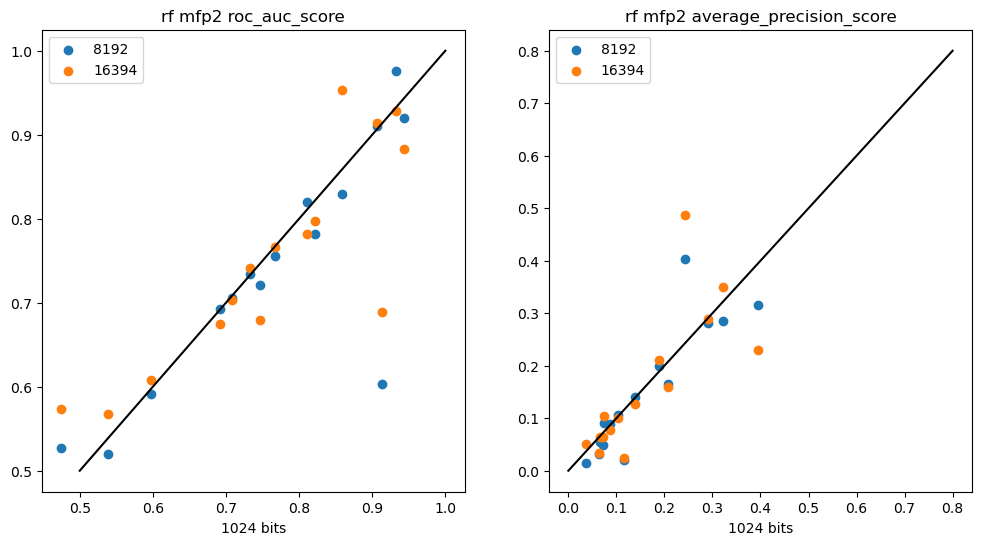

In [52]:
do_plots('rf','mfp2',accum)

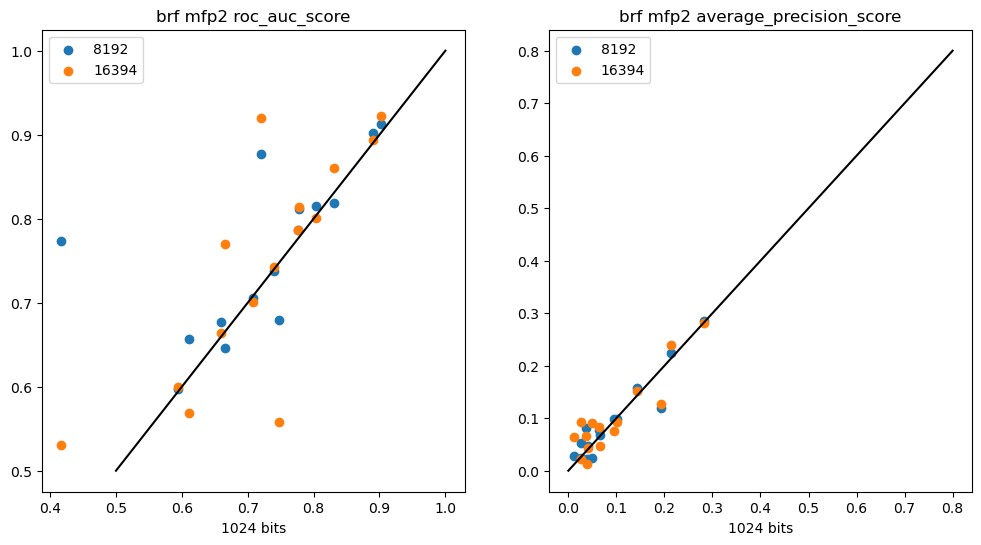

In [53]:
do_plots('brf','mfp2',accum)

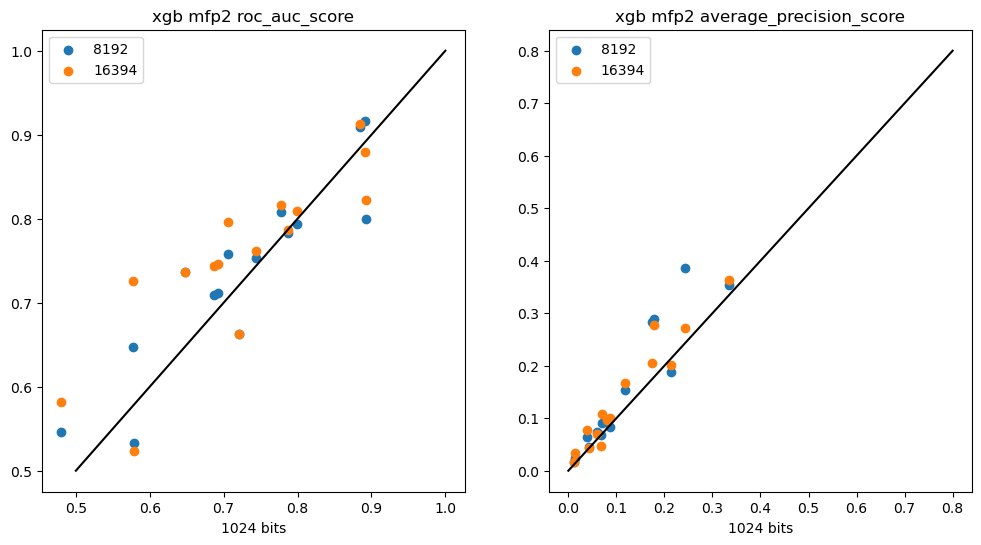

In [54]:
do_plots('xgb','mfp2',accum)

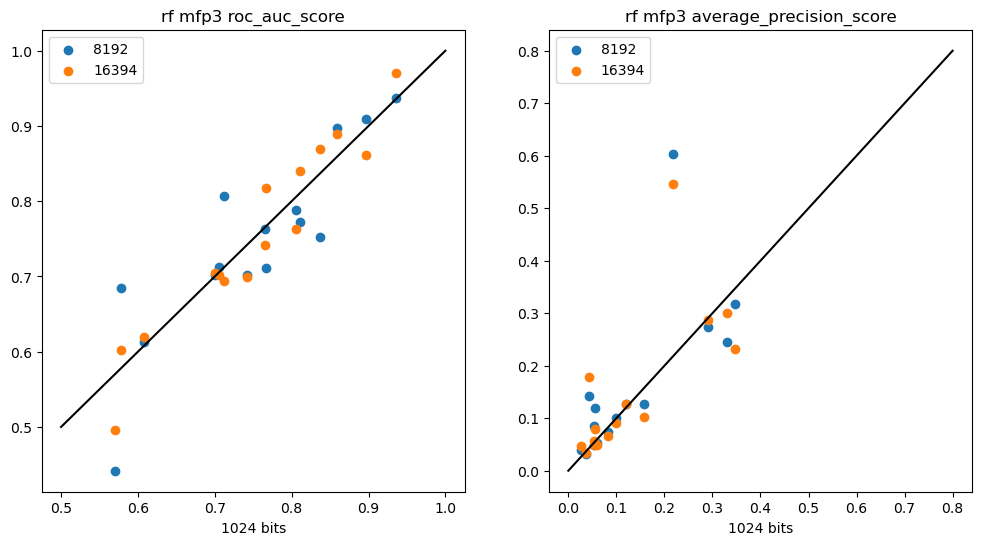

In [55]:
do_plots('rf','mfp3',accum)

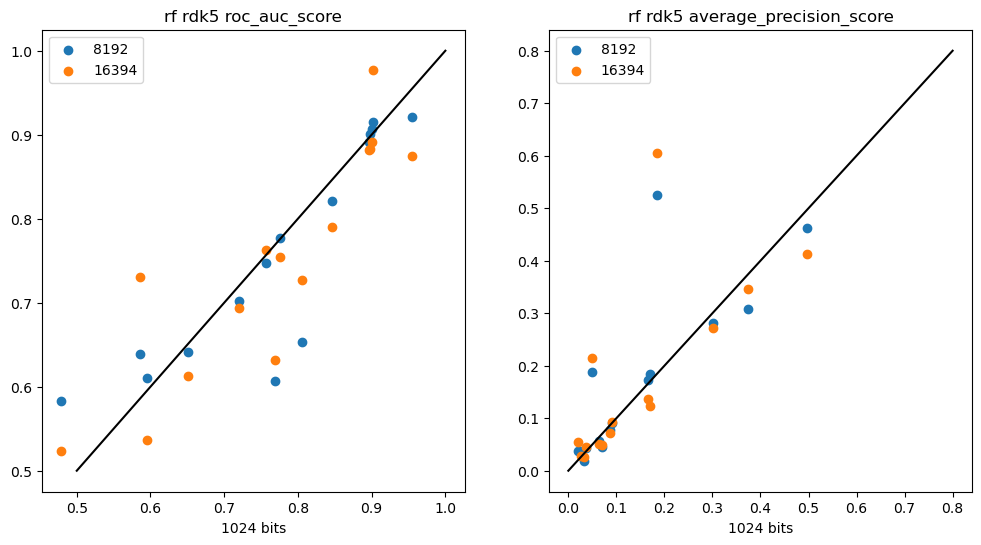

In [56]:
do_plots('rf','rdk5',accum)

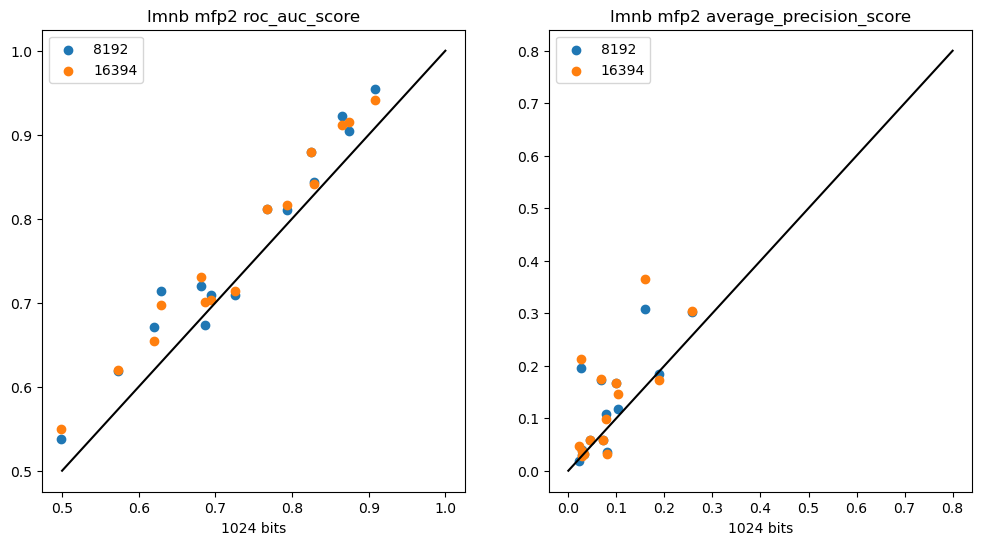

In [73]:
do_plots('lmnb','mfp2',accum)

In [71]:
from bayes.LaplacianNB import LaplacianNB
taccum = defaultdict(dict)

for fpcnt in (1024,8192,16394):   
    print(f'-------------- {fpcnt} Bits')
    for nm,fpg in gens:
        print(f'  --------- {nm}')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for tgt in datasets:
            if fpkey in taccum['lmnb'] and tgt in taccum['lmnb'][fpkey]:
                continue

            print('  lmnb')
            cls =  LaplacianNB(alpha=1.0, fit_prior=True)
            if fpkey not in taccum['lmnb']:
                taccum['lmnb'][fpkey] = defaultdict(dict)
            taccum['lmnb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,inactMult=100,sparse=True)



-------------- 1024 Bits
  --------- mfp2
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ADRB2
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ALDH1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandru

   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ago
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/ESR1_ant
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/L

Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/FEN1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/GBA
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM

   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/IDH1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/KAT2A
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MAPK1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/MTORC1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/OPRK1
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PKM2
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITPCBA/AVE_unbiased/PPARG
   Reading fingerprints
   Building model
Done!
  lmnb
*** Running target /home/glandrum/localhome/Code/LITP

In [74]:
with open('bak.downsample.pkl','wb+') as outf:
    pickle.dump(accum,outf)


In [75]:
from scipy import stats

In [78]:
def do_significance(alg,fp,tableOutput=False,showHeader=False,pthresh=0.001,accum=accum,metrics=metrics):
  
    v1s = defaultdict(list)
    v2s = defaultdict(list)
    delts = defaultdict(list)
    pct_delts = defaultdict(list)

    if tableOutput and showHeader:
        row = ('alg','fp','metric','result','P','delt','pct_delt')
        divider = ['-'*len(k) for k in row]
        print('| '+' | '.join(row)+' |')
        print('| '+' | '.join(divider)+' |')
        
        
    res1 = accum[alg][f'{fp}-1024']
    res2 = accum[alg][f'{fp}-16394']
    
    for d1,d2 in zip(res1.values(),res2.values()):
        for metric in metrics:
            v1 = d1[metric]
            v2 = d2[metric]
            v1s[metric].append(v1)
            v2s[metric].append(v2)
            delt = v1-v2
            delts[metric].append(delt)
            pct_delts[metric].append(delt/v1)
    for metric in metrics:
        w2s = stats.wilcoxon(v1s[metric],v2s[metric],alternative='two-sided').pvalue
        wlt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='less').pvalue
        wgt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='greater').pvalue
        result = 'same'
        which = w2s
        if wlt<pthresh or wgt<pthresh:
            if wlt < pthresh:
                result = 'lt'
                which = wlt
            elif wgt < pthresh:
                result = 'gt'
                which = wgt
        elif w2s<pthresh:
            result='diff'
        row = (alg,fp,metric,result,f'{which:.3g}',f'{np.median(delts[metric]):.2g}',f'{np.median(pct_delts[metric]):.3g}')
        if not tableOutput:
            print(' '.join(row))
        else:
            print('| '+' | '.join(row)+' |')

In [79]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 9.16e-05 | -0.041 | -0.0532 |
| lmnb | mfp3 | roc_auc_score | same | 0.0125 | -0.03 | -0.0382 |
| lmnb | rdk5 | roc_auc_score | same | 0.89 | 0.0012 | 0.00145 |
| lmnb | hashap | roc_auc_score | same | 0.252 | -0.013 | -0.0202 |
| lmnb | hashtt | roc_auc_score | same | 0.00427 | -0.044 | -0.0565 |
| rf | mfp2 | roc_auc_score | same | 0.639 | 0.0031 | 0.00335 |
| rf | mfp3 | roc_auc_score | same | 0.978 | -0.0036 | -0.00508 |
| rf | rdk5 | roc_auc_score | same | 0.169 | 0.022 | 0.0281 |
| rf | hashap | roc_auc_score | same | 0.208 | -0.018 | -0.0218 |
| rf | hashtt | roc_auc_score | same | 0.561 | 0.002 | 0.00389 |
| brf | mfp2 | roc_auc_score | same | 0.151 | -0.0056 | -0.00937 |
| brf | mfp3 | roc_auc_score | same | 0.135 | -0.016 | -0.018 |
| brf | rdk5 | roc_auc_score | same | 0.33 | 0.012 | 0.0132 |
| brf | hashap | roc_auc_

In [80]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,),
                           pthresh=0.01)
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 9.16e-05 | -0.041 | -0.0532 |
| lmnb | mfp3 | roc_auc_score | lt | 0.00623 | -0.03 | -0.0382 |
| lmnb | rdk5 | roc_auc_score | same | 0.89 | 0.0012 | 0.00145 |
| lmnb | hashap | roc_auc_score | same | 0.252 | -0.013 | -0.0202 |
| lmnb | hashtt | roc_auc_score | lt | 0.00214 | -0.044 | -0.0565 |
| rf | mfp2 | roc_auc_score | same | 0.639 | 0.0031 | 0.00335 |
| rf | mfp3 | roc_auc_score | same | 0.978 | -0.0036 | -0.00508 |
| rf | rdk5 | roc_auc_score | same | 0.169 | 0.022 | 0.0281 |
| rf | hashap | roc_auc_score | same | 0.208 | -0.018 | -0.0218 |
| rf | hashtt | roc_auc_score | same | 0.561 | 0.002 | 0.00389 |
| brf | mfp2 | roc_auc_score | same | 0.151 | -0.0056 | -0.00937 |
| brf | mfp3 | roc_auc_score | same | 0.135 | -0.016 | -0.018 |
| brf | rdk5 | roc_auc_score | same | 0.33 | 0.012 | 0.0132 |
| brf | hashap | roc_auc_sco